In [2]:
import os
import sys
import time
import json
import datetime
import random
import tarfile

import numpy as np
import pandas as pd
from PIL import Image
PATH = "../tubs/tub5" #Shadow

In [3]:
#make sure tensorflow version is the same as one installed on donkeycar (1.8.0)
import tensorflow as tf
print(tf.__version__)

1.8.0


In [4]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

['/device:GPU:0']

In [4]:
#create df from path
def df_from_jsons(PATH, max_items=None):
    
    #Get json files from path
    json_files = [file for file in os.listdir(PATH) if file.endswith('json') ]
    
    df = pd.DataFrame()
    for i, j in enumerate(json_files[1:max_items]):
        with open(f'{PATH}/{j}') as f:
            data = json.load(f)

            userThrottle = data["user/throttle"]
            userAngle = data["user/angle"]
            camImage_path = data["cam/image_array"]
            index = int(camImage_path[:-21])
            camImage_path =  PATH + "/" + camImage_path
            df_row = pd.DataFrame([[userThrottle, userAngle, camImage_path]], index = [index], 
                                  columns = ["user/throttle", "user/angle", "cam/image_array"])

            df = df.append(df_row)
    df = df.sort_index()
    print("Loaded {} json files".format(len(json_files)))
    return df

In [18]:
#df = df_from_jsons(PATH, max_items=None)

Loaded 38575 json files


In [45]:
#df.to_feather('tmp/df_wPath_extra')

In [5]:
df = pd.read_feather('tmp/df_wPath')

C:\Users\Jason\Anaconda3\envs\tf-gpu\lib\site-packages\pandas\io\feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [6]:
df.shape

(38574, 3)

In [7]:
df.head()

,user/throttle,user/angle,cam/image_array
0,0.08,0.01,../tubs/tub5/0_cam-image_array_.jpg
1,0.12,-0.03,../tubs/tub5/1_cam-image_array_.jpg
2,0.12,-0.03,../tubs/tub5/2_cam-image_array_.jpg
3,0.14,-0.06,../tubs/tub5/3_cam-image_array_.jpg
4,0.14,-0.06,../tubs/tub5/4_cam-image_array_.jpg


In [8]:
X_keys = ['cam/image_array']
y_keys = ['user/angle', 'user/throttle']
PATH
new_model_path = 'models/pilot_jn'
bs = 128
train_frac = 0.8

In [9]:
def to_bin(a):
    arr = np.zeros(15)
    a = a + 1
    b = round(a/(2/14))
    arr[int(b)] = 1
    return arr

In [16]:
def read_record(record_dict, path = PATH, grayscale = True):
    data = {}
    for key, val in record_dict.items():
        if key == 'cam/image_array':
            img = Image.open(f'{val}')
            if grayscale:
                img = img.convert("L")
                val = np.array([np.array(img)])
            else:
                val = np.array(img)
        
        data[key] = val
    return data

In [17]:
#Testing
df_t = df.sample(n=1).to_dict(orient='record')[0]
record = read_record(df_t)
data = record['cam/image_array']
data.shape

(1, 120, 160)

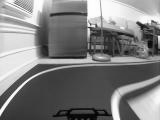

In [18]:
Image.fromarray(data[0], "L")

In [19]:
pic_gray=pic.convert("L")
pic_gray

NameError: name 'pic' is not defined

In [46]:
pic_gray_arr = np.array(pic_gray)

In [48]:
pic_gray_arr.shape

(120, 160)

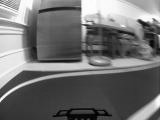

In [49]:
Image.fromarray(pic_gray_arr, "L")

In [20]:
def get_record_gen(record_transform=None, shuffle=True, df=None):
    while True:
        for _ in df.iterrows():
            if shuffle:
                record_dict = df.sample(n=1).to_dict(orient='record')[0]
            
            record_dict = read_record(record_dict)
            
            if record_transform:
                record_dict = record_transform(record_dict)
            
            yield record_dict

In [21]:
# record_gen = get_record_gen(record_transform=None, shuffle=True, df=df)

In [22]:
# next(record_gen)

In [23]:
def get_batch_gen(keys=None, batch_size=128, record_transform=None, shuffle=True, df=None):
    
    record_gen = get_record_gen(record_transform=record_transform, shuffle=shuffle, df=df)
    
    while True:
        record_list = [next(record_gen) for _ in range(batch_size)]
        
        batch_arrays = {}
        for i, k in enumerate(keys):
            arr = np.array([r[k] for r in record_list])
            batch_arrays[k] = arr
        yield batch_arrays

In [24]:
def get_train_gen(X_keys, Y_keys, batch_size=128, record_transform=None, df=None): #
    batch_gen = get_batch_gen(X_keys + Y_keys, batch_size=batch_size,
                                  record_transform=record_transform, df=df)
    while True:
        batch = next(batch_gen)
        X = [batch[k] for k in X_keys]
        Y = [batch[k] for k in Y_keys] 
        yield X, Y

In [25]:
def get_train_val_gen(df, X_keys, Y_keys, batch_size = 128, train_frac=0.8, #
                      train_record_transform=None, val_record_transform=None): #
    train_df = df.sample(frac=train_frac, random_state=200) #
    val_df = df.drop(train_df.index) #
    
    train_gen = get_train_gen(X_keys=X_keys, Y_keys=Y_keys, batch_size=batch_size,
                             record_transform=train_record_transform, df=train_df)
    val_gen = get_train_gen(X_keys=X_keys, Y_keys=Y_keys, batch_size=batch_size,
                           record_transform=val_record_transform, df=val_df)
    return train_gen, val_gen
    

In [26]:
def record_transform(record):
    record['user/angle'] = to_bin(record['user/angle'])
    return record

In [27]:
train_gen, val_gen = get_train_val_gen(df, X_keys, y_keys,
                                               train_record_transform=record_transform, #
                                               val_record_transform=record_transform, #
                                               batch_size=bs, #
                                               train_frac=train_frac) #

In [28]:
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Convolution2D
from tensorflow.python.keras.layers import Dropout, Flatten, Dense, Cropping2D, Lambda
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

In [33]:
def default_categorical():
    img_in = Input(shape=(1, 120, 160),
                   name='img_in')  # First layer, input layer, Shape comes from camera.py resolution, RGB
    x = img_in
    x = Convolution2D(24, (5, 5), strides=(2, 2), activation='relu', data_format="channels_first")(
        x)  # 24 features, 5 pixel x 5 pixel kernel (convolution, feauture) window, 2wx2h stride, relu activation
    x = Convolution2D(32, (5, 5), strides=(2, 2), activation='relu', data_format="channels_first")(
        x)  # 32 features, 5px5p kernel window, 2wx2h stride, relu activatiion
    x = Convolution2D(64, (5, 5), strides=(2, 2), activation='relu', data_format="channels_first")(
        x)  # 64 features, 5px5p kernal window, 2wx2h stride, relu
    x = Convolution2D(64, (3, 3), strides=(2, 2), activation='relu', data_format="channels_first")(
        x)  # 64 features, 3px3p kernal window, 2wx2h stride, relu
    x = Convolution2D(64, (3, 3), strides=(1, 1), activation='relu', data_format="channels_first")(
        x)  # 64 features, 3px3p kernal window, 1wx1h stride, relu

    # Possibly add MaxPooling (will make it less sensitive to position in image).  Camera angle fixed, so may not to be needed
    x = Dropout(0.5)(x)
    x = Flatten(name='flattened')(x)  # Flatten to 1D (Fully connected)
#     x = Dense(100, activation='relu')(x)  # Classify the data into 100 features, make all negatives 0
#     x = Dropout(.3)(x)  # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
    x = Dense(50, activation='relu')(x)  # Classify the data into 50 features, make all negatives 0
    x = Dropout(.5)(x)  # Randomly drop out 10% of the neurons (Prevent overfitting)
    # categorical output of the angle
    angle_out = Dense(15, activation='softmax', name='angle_out')(
        x)  # Connect every input with every output and output 15 hidden units. Use Softmax to give percentage. 15 categories and find best one based off percentage 0.0-1.0

    # continous output of throttle
    throttle_out = Dense(1, activation='relu', name='throttle_out')(x)  # Reduce to 1 number, Positive number only

    model = Model(inputs=[img_in], outputs=[angle_out, throttle_out])
    model.compile(optimizer='adam',
                  loss={'angle_out': 'categorical_crossentropy',
                        'throttle_out': 'mean_absolute_error'},
                  loss_weights={'angle_out': 0.9, 'throttle_out': .01})

    return model

In [34]:
model = default_categorical()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             (None, 1, 120, 160)  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 24, 58, 78)   624         img_in[0][0]                     
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 32, 27, 37)   19232       conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 64, 12, 17)   51264       conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (

In [35]:
def train(train_gen, val_gen, saved_model_path, epochs=100, steps=100, train_split=0.8,
         verbose=1, min_delta=0.0005, patience=5, use_early_stop=True):
    
#     checkpoint to save model
    save_best = ModelCheckpoint(saved_model_path, monitor='val_loss', verbose=verbose, save_best_only=True, mode='min')
    
    #stop training if stop improving
    early_stop = EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=patience, verbose=verbose, mode='auto')
    
    callbacks_list = [save_best]
    
    if use_early_stop:
        callbacks_list.append(early_stop)
        
    hist = model.fit_generator(train_gen, steps_per_epoch=steps, epochs=epochs, verbose=1, validation_data=val_gen,
                                callbacks=callbacks_list, validation_steps=steps * (1.0 - train_frac)//train_frac)
    return hist

In [36]:
total_records = len(df)
total_train = int(total_records * train_frac)
total_val = total_records - total_train
steps_per_epoch = total_train // bs
steps_per_epoch

241

In [37]:
train(train_gen, val_gen, saved_model_path=new_model_path, steps=steps_per_epoch, train_split=0.8) #change train_split to 0.9 for large data

Epoch 1/100
240/241 [============================>.] - ETA: 0s - loss: 1.9963 - angle_out_loss: 2.2125 - throttle_out_loss: 0.5039
Epoch 00001: val_loss improved from inf to 1.46372, saving model to models/pilot_jn
241/241 [==============================] - 98s 405ms/step - loss: 1.9951 - angle_out_loss: 2.2111 - throttle_out_loss: 0.5033 - val_loss: 1.4637 - val_angle_out_loss: 1.6230 - val_throttle_out_loss: 0.2989
Epoch 2/100
240/241 [============================>.] - ETA: 0s - loss: 1.5367 - angle_out_loss: 1.7037 - throttle_out_loss: 0.3349
Epoch 00002: val_loss improved from 1.46372 to 1.34045, saving model to models/pilot_jn
241/241 [==============================] - 82s 341ms/step - loss: 1.5365 - angle_out_loss: 1.7035 - throttle_out_loss: 0.3348 - val_loss: 1.3404 - val_angle_out_loss: 1.4858 - val_throttle_out_loss: 0.3193
Epoch 3/100
240/241 [============================>.] - ETA: 0s - loss: 1.4256 - angle_out_loss: 1.5804 - throttle_out_loss: 0.3204
Epoch 00003: val_loss i

Epoch 21/100
240/241 [============================>.] - ETA: 0s - loss: 0.8400 - angle_out_loss: 0.9329 - throttle_out_loss: 0.0401
Epoch 00021: val_loss improved from 0.94947 to 0.90065, saving model to models/pilot_jn
241/241 [==============================] - 80s 330ms/step - loss: 0.8402 - angle_out_loss: 0.9331 - throttle_out_loss: 0.0401 - val_loss: 0.9006 - val_angle_out_loss: 1.0003 - val_throttle_out_loss: 0.0361
Epoch 22/100
240/241 [============================>.] - ETA: 0s - loss: 0.8266 - angle_out_loss: 0.9180 - throttle_out_loss: 0.0405
Epoch 00022: val_loss did not improve
241/241 [==============================] - 80s 331ms/step - loss: 0.8265 - angle_out_loss: 0.9179 - throttle_out_loss: 0.0405 - val_loss: 0.9188 - val_angle_out_loss: 1.0205 - val_throttle_out_loss: 0.0366
Epoch 23/100
240/241 [============================>.] - ETA: 0s - loss: 0.8068 - angle_out_loss: 0.8960 - throttle_out_loss: 0.0403
Epoch 00023: val_loss did not improve
241/241 [===================

In [5]:
"""
Records

Original architecture with 79k samples
498/498 [==============================] - 215s 432ms/step - loss: 0.4393 - angle_out_loss: 0.4875 
- throttle_out_loss: 0.0551 - val_loss: 0.8894 - val_angle_out_loss: 0.9876 - val_throttle_out_loss: 0.0586
Epoch 00028: early stopping

Original architecture with 79k samples and 0.2 and 0.3 dropout at the end
498/498 [==============================] - 239s 480ms/step - loss: 0.5324 - angle_out_loss: 0.5910 - 
throttle_out_loss: 0.0585 - val_loss: 0.9268 - val_angle_out_loss: 1.0292 - val_throttle_out_loss: 0.0530
Epoch 00030: early stopping

Original architecture with 79k samples and 0.3 and 0.5 dropout at the end

Original architecture minus Dense(100) with 30k samples

"""



'\nRecords\n\nOriginal architecture with 79k samples\n498/498 [==============================] - 215s 432ms/step - loss: 0.4393 - angle_out_loss: 0.4875 \n- throttle_out_loss: 0.0551 - val_loss: 0.8894 - val_angle_out_loss: 0.9876 - val_throttle_out_loss: 0.0586\nEpoch 00028: early stopping\n\nOriginal architecture with 79k samples and 0.2 and 0.3 dropout at the end\n498/498 [==============================] - 239s 480ms/step - loss: 0.5324 - angle_out_loss: 0.5910 - \nthrottle_out_loss: 0.0585 - val_loss: 0.9268 - val_angle_out_loss: 1.0292 - val_throttle_out_loss: 0.0530\nEpoch 00030: early stopping\n\nOriginal architecture with 79k samples and 0.3 and 0.5 dropout at the end\n\n'

In [175]:
#check against original
def unbin(arr):
    index = np.argmax(arr)
    return index/14*2-1
#     return index

In [174]:
unbin([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

0.0

In [176]:
def run(img_arr):
    img_arr = img_arr.reshape((1,) + img_arr.shape)
    angle_binned, throttle = model.predict(img_arr)
    angle_unbinned = unbin(angle_binned[0])
    return angle_unbinned, throttle[0][0]

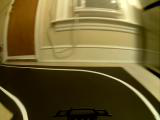

In [194]:
img_name = df['cam/image_array'][150]
img = Image.open(f'{PATH}/{img_name}')
img

In [195]:
val = np.array(img)

In [196]:
val.shape

(120, 160, 3)

In [198]:
#prediction
run(val)

(-0.4285714285714286, 0.31011686)

In [199]:
#compare to actual data
df['user/angle'][150], df['user/throttle'][150]

(-0.42, 0.27)